In [1]:
import numpy as np
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import time
import scipy.io as sio
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy
from sklearn.metrics import roc_auc_score

## Configs

In [2]:
num_workers = 2
sets_sizes = {'train' : 0.7,
              'test' : 0.3}
batch_size = 64
edge_size = 28
input_size = edge_size * edge_size
output_size = 10
epochs_num = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

cpu


## loading mnist dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# download and load the dataset mnist784 with 70000 images
dataset = torch.utils.data.ConcatDataset([datasets.MNIST(root='./data', train=False, download=True, transform=transform),
                                          datasets.MNIST(root='./data', train=True, download=True, transform=transform)])

print(len(dataset))

70000


## splitting the train data to train and validation

In [4]:
# split the data into training and validation sets using torch.utils.data.random_split
train_size = int(sets_sizes['train'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

## creating dataloader for train, validation and test

In [5]:
class GpuDataLoader:
    def __init__(self, dl):
        self.dl = dl

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        return map(lambda batch: (batch[0].to(device), batch[1].to(device)), self.dl)

In [6]:
# creating dataloader for train, validation and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

if device.type == 'cuda':
    train_loader = GpuDataLoader(train_loader)
    test_loader = GpuDataLoader(test_loader)

## visualizing several images from the train_loader

batch of images shape:  torch.Size([64, 1, 28, 28])
batch of labels shape:  torch.Size([64])


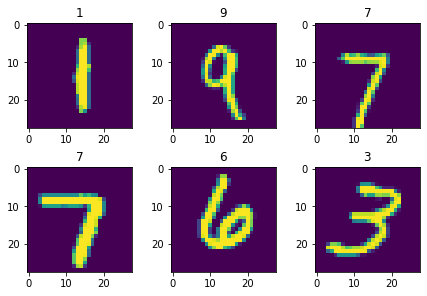

In [7]:
# get a single batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("batch of images shape: ", images.shape)
print("batch of labels shape: ", labels.shape)

# show batch 6 first images
fig, axs = plt.subplots(2, 3, constrained_layout=True)
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(images[idx].cpu().numpy().transpose((1, 2,0)))
    ax.set_title(str(labels[idx].item()))

## building the model

In [8]:
# fully connected neural network
class FC_Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=10):
        super(FC_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes

        # fully connected layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.Sigmoid())
        for i in range(len(hidden_sizes)-1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.layers:
            x = layer(x)
        return x

## training and score calculation

In [9]:
def calc_acc(model, set='train'):
  if set == 'train':
      loader = train_loader
  elif set == 'val':
      loader = val_loader
  elif set == 'test':
      loader = test_loader
  else:
      raise ValueError('set must be one of train, val, test')

  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in loader:

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.shape[0]
      correct += (predicted == labels).sum().item()
  return correct / total

def calc_loss(model, set='train'):
  if set == 'train':
    loader = train_loader
  elif set == 'val':
    loader = val_loader
  elif set == 'test':
    loader = test_loader
  else:
    raise ValueError('set must be one of train, val, test')

  loss = 0
  with torch.no_grad():
    for images, labels in loader:
      outputs = model(images)
      loss += F.mse_loss(outputs, torch.Tensor(int_to_onehot(labels, output_size)))
  return loss / len(loader)

In [10]:
def train_model(model, epochs_num=30, lr=0.001, log_dir=None):
  writer = SummaryWriter(log_dir=log_dir)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  for epoch in tqdm(range(epochs_num)):
    for idx, batch in enumerate(train_loader):
      X, y = batch

      output = model(X)
      loss = criterion(output, torch.Tensor(int_to_onehot(y, output_size)))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # log the losses and accuracy after every epoch
    writer.add_scalar('Loss/train', calc_loss(model, set='train'), epoch)
    writer.add_scalar('Accuracy/train', calc_acc(model, set='train'), epoch)
    writer.flush()

    # save model checkpoints after every 5 epochs
    if epoch % 5 == 0:
          torch.save(model.state_dict(), os.path.join(log_dir, 'model_epoch_{}.pt'.format(epoch)))

  writer.close()

## Training net

In [13]:
def int_to_onehot(y, num_labels):
    
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

In [14]:
# if model not exist, training it
hidden_sizes = [50,50]
model_path = './model_torch_fc_2_layers.pt'
fc_model = FC_Model(input_size, hidden_sizes, output_size).to(device)
if not os.path.exists(model_path):
    train_model(fc_model, epochs_num=epochs_num, log_dir='./runs/fc_torch/' + str(hidden_sizes))
    torch.save(fc_model.state_dict(), model_path)
else:
    fc_model.load_state_dict(torch.load(model_path))

100%|██████████| 40/40 [15:11<00:00, 22.79s/it]


In [15]:
# convert test_dataset to tensor X_test and y_test
X_test = torch.Tensor([]).view(-1, input_size)
y_test = torch.Tensor([])
for images, labels in test_loader:
    images = images.view(-1, input_size)
    X_test = torch.cat((X_test, images.cpu()))
    y_test = torch.cat((y_test, labels.cpu()))


In [16]:
print(f"Model acc on test set: ", round(calc_acc(fc_model, set='test') * 100, 3), '%') 

Model acc on test set:  96.638 %


In [17]:
probs = fc_model(X_test).detach().numpy()
probs = np.array([x / np.sum(x) for x in probs])
test_macro_auc = roc_auc_score(y_test, probs, average='macro', multi_class='ovr')
print(f'Model macro auc on test set: {round(test_macro_auc * 100, 3)}', '%')

Model macro auc on test set: 99.742 %
